In [1]:
# Common imports
import sys
import os 
import sklearn
import numpy as np

# Tensorflow and keras import
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# RandomizeSearchCV, RandomForrestClassifier, GradientBoostingClassifier import
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

# Make this notebooks output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# Load Dataset

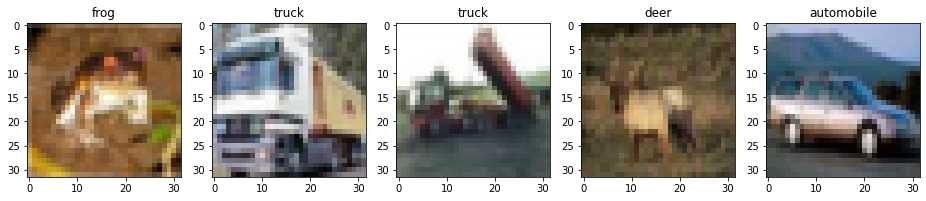

In [2]:
# Load CIFAR10 dataset and split into test and train dataset
# Then display the first 5 image from the dataset with the corresponding label they have
cifar10 = tf.keras.datasets.cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=[16, 9])
for i in range(len(axes)):
    axes[i].set_title(class_names[y_train_full[i, 0]])
    axes[i].imshow(X_train_full[i])

# Data Preparation

In [3]:
# Scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.
X_train = X_train_full[:] / 255.
X_test = X_test[:] / 255.

In [4]:
# Flattening the image array which is initially a 3D array,
# After flattening and reshapeing is being used it will be a 2D array
# 50000/10000 numbers of images, and 3072 is comming from 32x32x3
x_train_flat= X_train.flatten().reshape(50000,3072)
x_test_flat= X_test.flatten().reshape(10000,3072)

# Flattening the label array from 2D to 1D array
y_train_flat = y_train_full.flatten()
y_test_flat = y_test.flatten()

# Train and Evaluate Models
Hyperparameter tuning is also being done this part

In [5]:
# Train a model that is fine tuned manually
rnd_clf = RandomForestClassifier(max_depth=25, n_estimators=538, n_jobs=-1, bootstrap=False, random_state=42)
rnd_clf.fit(x_train_flat,y_train_flat)

RandomForestClassifier(bootstrap=False, max_depth=25, n_estimators=538,
                       n_jobs=-1, random_state=42)

In [6]:
# Evaluation the model
from sklearn.metrics import accuracy_score
y_pred = rnd_clf.predict(x_test_flat)
accuracy_score(y_test_flat, y_pred)

0.5033

In [7]:
# Train a model with the best params result of the first run of RandomizedSearchCV
rnd_clf = RandomForestClassifier(max_depth=10, n_estimators=500, n_jobs=-1, bootstrap=False, random_state=42)
rnd_clf.fit(x_train_flat,y_train_flat)

RandomForestClassifier(bootstrap=False, max_depth=10, n_estimators=500,
                       n_jobs=-1, random_state=42)

In [8]:
# Evaluation the model
from sklearn.metrics import accuracy_score
y_pred = rnd_clf.predict(x_test_flat)
accuracy_score(y_test_flat, y_pred)

0.4388

In [7]:
# Setting up the paramaters for RandomizedSearchCV using RandomForestClassifier parameters
# Number of estimators is an evenly spaced numbers of array between 50 and 600
# Max depth is an evenly spaced numbers of array between 10 and 100
n_estimators = [int(x) for x in np.linspace(start = 50 , stop = 600, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators, 'max_depth': max_depth,'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [50, 111, 172, 233, 294, 355, 416, 477, 538, 600], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'bootstrap': [True, False]}


In [7]:
# Train RandomSearchCV for RandomForestClassifierwith CV set to 3, verbose set to 2 and 15 iterations will be done per each CV.
random_search_cv = RandomizedSearchCV(RandomForestClassifier(random_state=42), 
                                      param_distributions=random_grid, n_iter = 15, 
                                      cv = 3, verbose=2, random_state=42, n_jobs=-1,
                                      return_train_score=True)
random_search_cv.fit(x_train_flat, y_train_flat)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 34.5min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 61.0min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'n_estimators': [50, 111, 172, 233, 294,
                                                         355, 416, 477, 538,
                                                         600]},
                   random_state=42, return_train_score=True, verbose=2)

In [8]:
# Evaluationg the RandomSearchCV's best params
print(random_search_cv.best_params_)
y_pred = random_search_cv.predict(x_test_flat)
print(accuracy_score(y_test_flat, y_pred))

{'n_estimators': 538, 'max_depth': 60, 'bootstrap': False}
0.5029


In [12]:
# Setting up the paramaters for RandomizedSearchCV using GradientBoostingClassifier parameters
# Number of estimators is an evenly spaced numbers of array between 2 and 15
# Max depth is an evenly spaced numbers of array between 3 and 10
# Learning rate is an evenly spaced numbers of array between 0.1 and 1.0
# Learning rate is an evenly spaced numbers of array between 0.1 and 1.0
# Number of iteration no change is evenly spaced numbers of array between 3 and 10, terminate training when validation score is not improving
# Tolerance is an evenly spaced numbers of array between 0.01 and 0.5, tolerance for the early stopping. 

n_estimators = [int(x) for x in np.linspace(start = 2 , stop = 15, num = 10)]
max_depth = [int(x) for x in np.linspace(3, 10, num = 10)]
learning_rate= [float(x) for x in np.linspace(0.1, 1.0, num = 10)]
n_iter_no_change= [int(x) for x in np.linspace(3, 10, num = 8)]
tol = [float(x) for x in np.linspace(0.01, 0.5, num = 5)]
random_grid_gbcl = {'n_estimators': n_estimators, 'max_depth': max_depth,'learning_rate': learning_rate, 'n_iter_no_change': n_iter_no_change,'tol': tol}

print(random_grid_gbcl)

{'n_estimators': [2, 3, 4, 6, 7, 9, 10, 12, 13, 15], 'max_depth': [3, 3, 4, 5, 6, 6, 7, 8, 9, 10], 'learning_rate': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 1.0], 'n_iter_no_change': [3, 4, 5, 6, 7, 8, 9, 10], 'tol': [0.01, 0.1325, 0.255, 0.3775, 0.5]}


In [13]:
# Train RandomSearchCV for GradientBoostingClassifier with CV set to 3, verbose set to 2 and 15 iterations will be done per each CV.
random_search_cv_gbcl = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), 
                                      param_distributions=random_grid_gbcl, n_iter = 15, 
                                      cv = 3, verbose=2, random_state=42, n_jobs=-1,
                                      return_train_score=True)
random_search_cv_gbcl.fit(x_train_flat, y_train_flat)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 109.1min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 197.3min finished


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.2,
                                                          0.30000000000000004,
                                                          0.4, 0.5, 0.6,
                                                          0.7000000000000001,
                                                          0.8, 0.9, 1.0],
                                        'max_depth': [3, 3, 4, 5, 6, 6, 7, 8, 9,
                                                      10],
                                        'n_estimators': [2, 3, 4, 6, 7, 9, 10,
                                                         12, 13, 15],
                                        'n_iter_no_change': [3, 4, 5, 6, 7, 8,
                                                             9, 10],
                                        'tol': [0.01, 0.1325, 0.255, 0

In [14]:
# Evaluationg the RandomSearchCV's best params
print(random_search_cv_gbcl.best_params_)
y_pred = random_search_cv_gbcl.predict(x_test_flat)
print(accuracy_score(y_test_flat, y_pred))

{'tol': 0.01, 'n_iter_no_change': 8, 'n_estimators': 10, 'max_depth': 6, 'learning_rate': 0.2}
0.425
